In [13]:
import numpy as np
import pandas as pd, re, requests
from itertools import combinations
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.auto import tqdm
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [35]:
all_pairs = pd.read_csv('matrix/combined_score_all_pairs_5.csv')
all_pairs.head()

,code_i,code_j,jaccard,bert,medbert,mlm,llm,mean_cosine
0,Q31,Q32,0.049180,0.978781,0.963511,-0.002364,1.0,0.971146
1,Q32,Q31,0.049180,0.978781,0.963511,-0.002364,1.0,0.971146
2,V04,V05,0.000000,0.986656,0.954143,-0.068813,1.0,0.970400
3,V05,V04,0.000000,0.986656,0.954143,-0.068813,1.0,0.970400
4,N10,N11,0.024135,0.981564,0.956813,-0.038977,0.5,0.969189


In [38]:
all_pairs['jaccard'].describe()

count    3.085292e+06
mean     2.441334e-03
std      8.935153e-03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.389130e-03
max      7.491553e-01
Name: jaccard, dtype: float64

In [34]:
import pandas as pd

all_pairs = pd.read_csv("matrix/combined_score_all_pairs_5.csv")

# какие метрики сравниваем
methods = ["bert", "medbert", "mlm", "llm"]

# общий размер выборки
total = len(all_pairs)

# ───────────────────────────────────────────────────────────────
# 1. Consistent / «тривиальные» пары  (high Jaccard + high cosine)
# ───────────────────────────────────────────────────────────────
j_high = all_pairs["jaccard"].quantile(0.75)          # верхний квартиль Jaccard

trivial_stats = {}

for m in methods:
    m_high = all_pairs[m].quantile(0.75)              # верхний квартиль для метода
    mask = (all_pairs["jaccard"] > j_high) & (all_pairs[m] > m_high)
    trivial_stats[m] = {
        "count": mask.sum(),
        "share": mask.mean()            # то же самое / total
    }

# ───────────────────────────────────────────────────────────────
# 2. Non‑trivial пары  (high Jaccard + LOW cosine)
# ───────────────────────────────────────────────────────────────
nontrivial_stats = {}

for m in methods:
    m_low = all_pairs[m].quantile(0.25)               # нижний квартиль cosine
    mask = (all_pairs["jaccard"] > j_high) & (all_pairs[m] < m_low)
    nontrivial_stats[m] = {
        "count": mask.sum(),
        "share": mask.mean()
    }

# ───────────────────────────────────────────────────────────────
# 3. Итоговая табличка
# ───────────────────────────────────────────────────────────────
summary = pd.DataFrame({
    "method": methods,
    "trivial_count": [trivial_stats[m]["count"] for m in methods],
    "trivial_share": [trivial_stats[m]["share"] for m in methods],
    "nontrivial_count": [nontrivial_stats[m]["count"] for m in methods],
    "nontrivial_share": [nontrivial_stats[m]["share"] for m in methods],
})

print(summary.to_string(index=False, float_format="%.4f"))


 method  trivial_count  trivial_share  nontrivial_count  nontrivial_share
   bert         237712         0.0770            115692            0.0375
medbert         218592         0.0708            180574            0.0585
    mlm         194052         0.0629            192004            0.0622
    llm          29740         0.0096                 0            0.0000


In [ ]:
jaccard_thresh = all_pairs['jaccard'].quantile(0.75)
bert_thresh = all_pairs['bert'].quantile(0.75)
mlm_thresh = all_pairs['mlm'].quantile(0.75)
medbert_thresh = all_pairs['medbert'].quantile(0.75)
llm_thresh = all_pairs['llm'].quantile(0.75)

print('Consistant')

good_bert = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['bert']> bert_thresh)
]
print(len(good_bert))
print(len(good_bert)/len(all_pairs))

good_medbert = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['medbert'] > medbert_thresh)
]
print(len(good_medbert))
print(len(good_medbert)/len(all_pairs))

good_mlm = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['mlm'] > mlm_thresh)
]
print(len(good_mlm))
print(len(good_mlm)/len(all_pairs))

good_llm = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['llm'] > llm_thresh)
]
print('good_llm')
print(len(good_llm))
print(len(good_llm)/len(all_pairs))

print('Non-trivial')
jaccard_thresh = all_pairs['jaccard'].quantile(0.75)
bert_thresh = all_pairs['bert'].quantile(0.25)
mlm_thresh = all_pairs['mlm'].quantile(0.25)
medbert_thresh = all_pairs['medbert'].quantile(0.25)
llm_thresh = all_pairs['llm'].quantile(0.25)

good_bert = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['bert']< bert_thresh)
]
print(len(good_bert))
print(len(good_bert)/len(all_pairs))

good_medbert = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['medbert'] < medbert_thresh)
]
print(len(good_medbert))
print(len(good_medbert)/len(all_pairs))

good_mlm = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['mlm'] < mlm_thresh)
]
print(len(good_mlm))
print(len(good_mlm)/len(all_pairs))

good_llm = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['llm'] < llm_thresh)
]
print('good_llm')
print(len(good_llm))
print(len(good_llm)/len(all_pairs))



In [33]:
jaccard_thresh = all_pairs['jaccard'].quantile(0.75)
bert_thresh = all_pairs['mean_cosine'].quantile(0.15)

filtr_pairs = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['mean_cosine'] < bert_thresh) &
    (all_pairs['code_i'].str[0] != all_pairs['code_j'].str[0]) 
    &  # разные категории
    (~all_pairs['code_i'].str.startswith('Z')) & 
    (~all_pairs['code_j'].str.startswith('Z'))                  # исключаем Z
]
filtr_pairs = filtr_pairs[['code_i', 'code_j', 'jaccard', 'bert', 'medbert', 'mean_cosine']]
print(filtr_pairs.sort_values(by = 'jaccard', ascending = False).head(50))


        code_i code_j   jaccard      bert   medbert  mean_cosine
2804341    E20    M11  0.333333  0.748507  0.433391     0.590949
2804340    M11    E20  0.333333  0.748507  0.433391     0.590949
2658677    I63    R29  0.295257  0.869135  0.356277     0.612706
2658676    R29    I63  0.295257  0.869135  0.356277     0.612706
2673973    R47    I63  0.285050  0.865232  0.356356     0.610794
2673972    I63    R47  0.285050  0.865232  0.356356     0.610794
3051568    I10    Y92  0.239095       NaN  0.472135     0.472135
3051569    Y92    I10  0.239095       NaN  0.472135     0.472135
2815267    I48    E78  0.235882  0.776710  0.401068     0.588889
2815266    E78    I48  0.235882  0.776710  0.401068     0.588889
2761132    R65    J96  0.233063  0.792371  0.404257     0.598314
2761133    J96    R65  0.233063  0.792371  0.404257     0.598314
2887074    N17    I48  0.230248  0.725015  0.420893     0.572954
2887075    I48    N17  0.230248  0.725015  0.420893     0.572954
2993611    K74    R18  0.

In [ ]:
all_pairs.sort_values(by='jaccard', ascending=False).head(500)


In [3]:
jaccard_thresh = all_pairs['jaccard'].quantile(0.75)
bert_thresh = all_pairs['bert'].quantile(0.75)
mlm_thresh = all_pairs['mlm'].quantile(0.75)
medbert_thresh = all_pairs['medbert'].quantile(0.75)
llm_thresh = all_pairs['llm'].quantile(0.75)


/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/3181231027.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'pics/jaccard_vs_bert.jpg', dpi=300, bbox_inches='tight')
/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/3181231027.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'pics/jaccard_vs_bert.jpg', dpi=300, bbox_inches='tight')
/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/3181231027.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/sofsen/miniconda3/envs/my_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


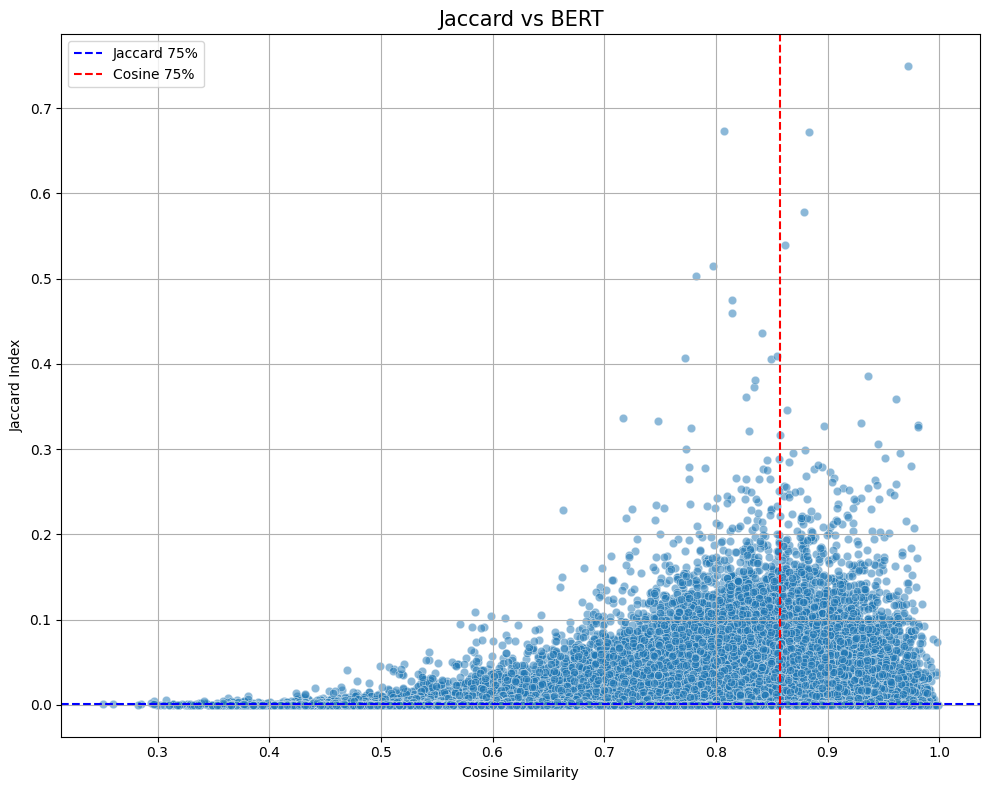

In [4]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=all_pairs,  
    x='bert',
    y='jaccard',
    alpha=0.3
)


plt.axhline(jaccard_thresh, color='blue', linestyle='--', label='Jaccard 75%')
plt.axvline(bert_thresh, color='red', linestyle='--', label='Cosine 75%')

plt.xlabel('Cosine Similarity')
plt.ylabel('Jaccard Index')
plt.title('Jaccard vs BERT', fontsize = 15)
plt.legend()
plt.grid(True)
plt.savefig(f'pics/jaccard_vs_bert.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/2463349303.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'pics/jaccard_vs_medbert.jpg', dpi=300, bbox_inches='tight')
/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/2463349303.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'pics/jaccard_vs_medbert.jpg', dpi=300, bbox_inches='tight')
/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/2463349303.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/sofsen/miniconda3/envs/my_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


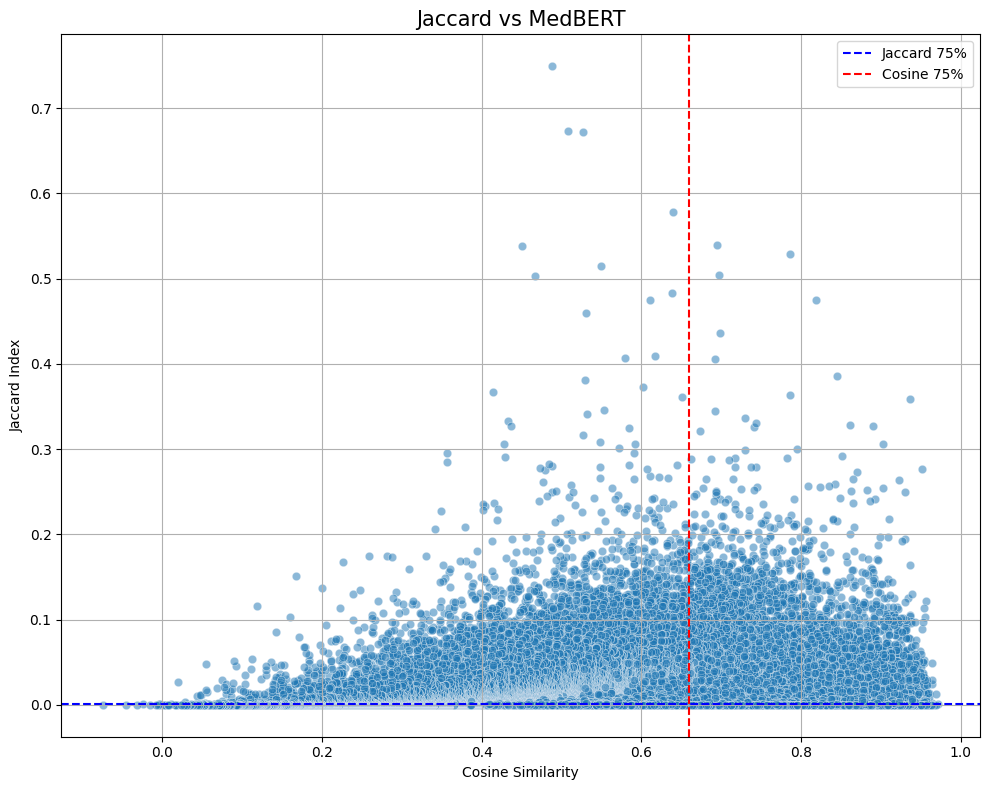

In [5]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=all_pairs,  
    x='medbert',
    y='jaccard',
    alpha=0.3
)



plt.axhline(jaccard_thresh, color='blue', linestyle='--', label='Jaccard 75%')
plt.axvline(medbert_thresh, color='red', linestyle='--', label='Cosine 75%')

plt.xlabel('Cosine Similarity')
plt.ylabel('Jaccard Index')
plt.title('Jaccard vs MedBERT', fontsize = 15)
plt.legend()
plt.grid(True)
plt.savefig(f'pics/jaccard_vs_medbert.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/2328023533.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'pics/jaccard_vs_mlm.jpg', dpi=300, bbox_inches='tight')
/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/2328023533.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'pics/jaccard_vs_mlm.jpg', dpi=300, bbox_inches='tight')
/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/2328023533.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/sofsen/miniconda3/envs/my_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


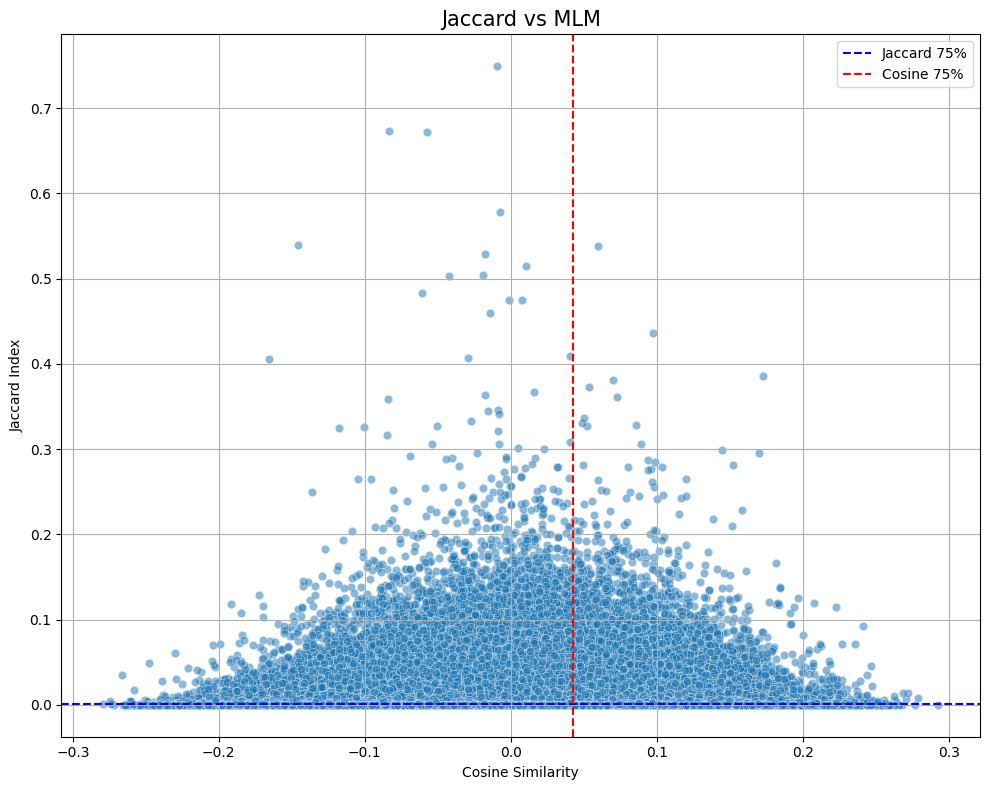

In [6]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=all_pairs,  
    x='mlm',
    y='jaccard',
    alpha=0.3
)

plt.axhline(jaccard_thresh, color='blue', linestyle='--', label='Jaccard 75%')
plt.axvline(mlm_thresh, color='red', linestyle='--', label='Cosine 75%')

plt.xlabel('Cosine Similarity')
plt.ylabel('Jaccard Index')
plt.title('Jaccard vs MLM', fontsize = 15)
plt.legend()
plt.grid(True)
plt.savefig(f'pics/jaccard_vs_mlm.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/3693373223.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'pics/jaccard_vs_llm.jpg', dpi=300, bbox_inches='tight')
/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/3693373223.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'pics/jaccard_vs_llm.jpg', dpi=300, bbox_inches='tight')
/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_10156/3693373223.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/sofsen/miniconda3/envs/my_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


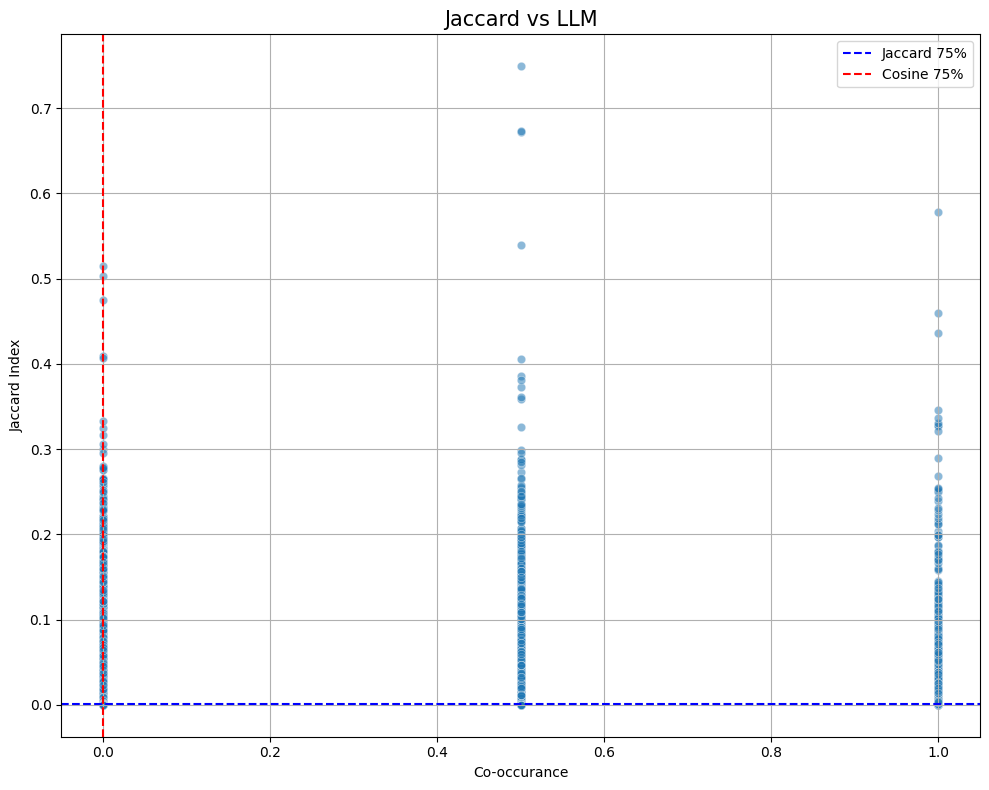

In [11]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=all_pairs,  
    x='llm',
    y='jaccard',
    alpha=0.3
)

plt.axhline(jaccard_thresh, color='blue', linestyle='--', label='Jaccard 75%')
plt.axvline(llm_thresh, color='red', linestyle='--', label='Cosine 75%')

plt.xlabel('Co-occurance')
plt.ylabel('Jaccard Index')
plt.title('Jaccard vs LLM', fontsize = 15)
plt.legend()
plt.grid(True)
plt.savefig(f'pics/jaccard_vs_llm.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [8]:
jaccard_thresh = all_pairs['jaccard'].quantile(0.75)
bert_thresh = all_pairs['bert'].quantile(0.75)
mlm_thresh = all_pairs['mlm'].quantile(0.75)
medbert_thresh = all_pairs['medbert'].quantile(0.75)
llm_thresh = all_pairs['llm'].quantile(0.75)


In [9]:
good_bert = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['bert'] > bert_thresh)
]
print('good_bert')
print(len(good_bert))
print(len(good_bert)/len(all_pairs))

good_medbert = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['medbert'] > medbert_thresh)
]
print('good_medbert')
print(len(good_medbert))
print(len(good_medbert)/len(all_pairs))


good_mlm = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['mlm'] > mlm_thresh)
]
print('good_mlm')
print(len(good_mlm))
print(len(good_mlm)/len(all_pairs))


good_llm = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['llm'] > llm_thresh)
]
print('good_llm')
print(len(good_llm))
print(len(good_llm)/len(all_pairs))





good_bert
237712
0.07704684029907055
good_medbert
218592
0.07084969591208871
good_mlm
194052
0.06289582963298125
good_llm
29740
0.009639282116571139


In [12]:
jaccard_thresh = all_pairs['jaccard'].quantile(0.75)
bert_thresh = all_pairs['bert'].quantile(0.25)
mlm_thresh = all_pairs['mlm'].quantile(0.25)
medbert_thresh = all_pairs['medbert'].quantile(0.25)
llm_thresh = all_pairs['llm'].quantile(0.25)

good_bert = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['bert']< bert_thresh)
]
print(len(good_bert))
print(len(good_bert)/len(all_pairs))

good_medbert = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['medbert'] < medbert_thresh)
]
print(len(good_medbert))
print(len(good_medbert)/len(all_pairs))

good_mlm = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['mlm'] < mlm_thresh)
]
print(len(good_mlm))
print(len(good_mlm)/len(all_pairs))

good_llm = all_pairs[
    (all_pairs['jaccard'] > jaccard_thresh) &
    (all_pairs['llm'] < llm_thresh)
]
print('good_llm')
print(len(good_llm))
print(len(good_llm)/len(all_pairs))





115692
0.03749790943612469
180574
0.058527361429647505
192004
0.06223203508776479
good_llm
0
0.0
